In [1]:
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

# зафиксируем сид для воспроизводимости генерации
SEED = 42
np.random.seed(SEED)
#random.seed(SEED)

## Множественная проверка гипотез

С помощью статистических методов можно проверить человека на наличие экстрасенсорных способностей: предложим ему угадать последовательность, состоящую из двух цветов, длины 100. 

Сформулируем задачу на статистическом языке: 

$X_1...X_{100}$ &mdash; выборка из распределения $Bern(p)$

$p=0.5$ отвечает случайному угадыванию.

Проверьте гипотезу: $\mathsf{H}_0 \colon p=0.5$ vs $\mathsf{H}_1 \colon p \neq 0.5$. Используйте критерий Вальда.

В качестве асимптотически нормальной оценки можно использовать $\widehat{p} = \overline{X}$ с асимптотической дисперсией $\sigma^2(p) = p (1 - p)$.

Выпишем состоятельную оценку дисперсии и статистику критерия Вальда:

$\widehat{\sigma} = \sqrt{\overline{X} (1 - \overline{X})}$, $W = \sqrt{n} \frac{\overline{X} - 0.5}{\sqrt{\overline{X} (1 - \overline{X})}}$

Оценим реальный уровень значимости для этого критерия при размере выборки равном 100. К чему он должен быть близок? Для скорости вычислений используйте количество выборок равное $10^3$.

In [8]:
sample_size = 100
sample_count = 1000

theta = 0.5

In [26]:
def wald_test(sample, theta, estimation_theta, estimation_sigma, alternative='two_sided'):
    """
    param sample: реализация выборки
    param theta: истинное значение параметра
    param estimation_theta: оценка параметра
    param estimation_sigma: оценка асимптотической дисперсии оценки estimation_sigma
    param alternative: вид альтернативной гипотезы, может принимать одно из значений 'two_sided', 'less', 'greater'

    return statistic
    return p_value
    """
    alpha = 0.05
    z = sps.norm.ppf(1 - alpha/2)
    n = len(sample)
    statistic = np.sqrt(n) * (estimation_theta - theta) / estimation_sigma

    if alternative == 'two_sided':
        p_value = sps.norm.sf(np.abs(statistic)) + sps.norm.cdf(-np.abs(statistic))
        conf_int = round(estimation_theta - z*estimation_sigma/np.sqrt(n), 4), round(estimation_theta + z*estimation_sigma/np.sqrt(n), 4)


    elif alternative == 'less':
        p_value = sps.norm.cdf(statistic)
        conf_int = (-np.inf, round(estimation_theta + z*estimation_sigma/np.sqrt(n), 4))

    
    elif alternative == 'greater':
        p_value = sps.norm.sf(statistic)
        conf_int = (round(estimation_theta + z*estimation_sigma/np.sqrt(n), 4), np.inf)

    else:
        raise ValueError('alternative name is wrong')

    return statistic, p_value, conf_int

Оценим реальный уровень значимости

In [20]:
sample = sps.bernoulli.rvs(0.5, size = (sample_count,sample_size))

estimation_theta = sample.mean(axis = 1)
estimation_sigma = np.sqrt(estimation_theta*(1-estimation_theta))


counter = 0

for i in range(sample_count):
    _, p_value, conf_int = wald_test(sample[i], theta, estimation_theta[i], estimation_sigma[i])
    is_rejected = (0.5 < conf_int[0])
    if is_rejected:
        counter += 1
        
counter / sample_count

0.031

Теперь представим, что мы хотим проверить большое количество людей на экстрасенсорные способности с помощью данного критерия.

Проведите аналогичный эксперимент: сгенерируйте $10^3$ выборок размера $100$ для $100$ людей. Посчитайте, сколько раз из 1000 в вашем наборе из 100 выборок хотя бы для одной гипотеза будет отвергнута. 

In [21]:
sample_all = sps.bernoulli.rvs(0.5, size = (sample_count,sample_size, sample_size))

counter = 0
for sample in sample_all:
    estimation_theta = sample.mean(axis = 1)
    estimation_sigma = np.sqrt(estimation_theta*(1-estimation_theta))

    for i in range(100):
        _, p_value, conf_int = wald_test(sample[i], theta, estimation_theta[i], estimation_sigma[i])
        is_rejected = (0.5 < conf_int[0])
        if is_rejected:
            counter += 1
            break

In [22]:
counter / 1000

0.943

**Вывод:** увеличение количества гипотез ведет к увеличению реального уровня значимости

На лекции вы прошли метод, позволяющий не накапливать ошибку 1 рода. В этом методе необходимо использовать уровень значимости, зависящий от количества проверяемых одновременно гипотез. 

**Чему равен этот уровень значимости, если одновременно проверяются n гипотез?**

**Ответ:** $\frac{\alpha}{n}$

Проведите предыдущий эксперимент с использованием корректной процедуры. Поскольку в реализованной выше функции $\alpha$ зафиксировано, используйте критерий отвержения гипотезы с помощью p-value.

In [27]:
sample_all = sps.bernoulli.rvs(0.5, size = (sample_count,sample_size, sample_size))
counter = 0
for sample in sample_all:
    estimation_theta = sample.mean(axis = 1)
    estimation_sigma = np.sqrt(estimation_theta*(1-estimation_theta))

    for i in range(100):
        _, p_value, conf_int = wald_test(sample[i], theta, estimation_theta[i], estimation_sigma[i])
        is_rejected = (p_value < 0.05/1000)
        if is_rejected:
            counter += 1
            break        

In [28]:
counter / 1000

0.013

**Вывод:** метод Бонферронекомпенсирует наблюдаемое увеличение реального уровня значимости, наблюдаемое раньше

## Критерии вида t-test

### Одновыборочный

Дана одна нормальная выборка $X_1, ..., X_n \sim \mathcal{N}(a, \sigma^2)$.

Критерий проверяет гипотезы

$\mathsf{H}_0\colon a = a_0$

$\mathsf{H}_1\colon a \not= a_0$ 

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html#scipy.stats.ttest_1samp">`ttest_1samp`</a>`(a, popmean): statistic, pvalue`

* `a` &mdash; выборка
* `popmean` &mdash; равно $a_0$

Сгенерируйте выборку $X_1, ..., X_n \sim \mathcal{N}(0, 1)$ и с помощью критерия проверьте:
- равенство среднего нулю 
- равенство среднего 0.5

In [42]:
size=100
a_zero1 = 0
a_zero2 = 0.5
sample = sps.norm.rvs(size = size)
_, pvalue = sps.ttest_1samp(sample, a_zero1)
print(pvalue.round(3))
_, pvalue = sps.ttest_1samp(sample, a_zero2)
print(pvalue.round(3))

0.171
0.0


Гипотезу о том, что среднее равно нулю мы не отвергаем

Гипотезу о том, что среднее равно 0.5 мы уверенно отвергаем

### Двухвыборочный

#### Независимые выборки

Даны две независимые нормальные выборки

* $X_1, ..., X_n \sim \mathcal{N}(a_1, \sigma_1^2)$,

* $Y_1, ..., Y_m \sim \mathcal{N}(a_2, \sigma_2^2)$.

Критерий проверяет для их гипотезы о равенстве среднего:

$\mathsf{H}_0\colon a_1 = a_2$

$\mathsf{H}_1\colon a_1 \not= a_2$ 

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind">`ttest_ind`</a>`(a, b, equal_var=True): statistic, pvalue`

`a`, `b` &mdash; выборка

`equal_var` &mdash; известно ли равенство дисперсий

Сгенерируйте выборки $X_1, ..., X_n \sim \mathcal{N}(0, 1)$ и $X_1, ..., X_m \sim \mathcal{N}(1, 1)$. Используя критерий, проверьте равенство средних двух выборок.

In [43]:
size = 100
sample_1 = sps.norm.rvs(size = size)
sample_2 = sps.norm.rvs(loc = 1, size = size)
_, pvalue = sps.ttest_ind(sample_1,sample_2)
print(pvalue)

1.4471634961288051e-07


смело отвергаем

Сгенерируйте выборки $X_1, ..., X_n \sim \mathcal{N}(0, 1)$ и $X_1, ..., X_m \sim \mathcal{N}(1, 7)$. Используя критерий, проверьте равенство средних двух выборок.

In [55]:
sample_1 = sps.norm.rvs(size = size)
sample_2 = sps.norm.rvs(loc = 1,scale = 7, size = size)
_, pvalue = sps.ttest_ind(sample_1,sample_2,equal_var=False)
print(pvalue)

0.39402968823483653


аналогично

#### Связные выборки

Даны две связные нормальные выборки

* $X_1, ..., X_n \sim \mathcal{N}(a_1, \sigma_1^2)$,

* $Y_1, ..., Y_n \sim \mathcal{N}(a_2, \sigma_2^2)$.


Критерий проверяет для их гипотезы о равенстве среднего:

$\mathsf{H}_0\colon a_1 = a_2$

$\mathsf{H}_1\colon a_1 \not= a_2$ 

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel">`ttest_rel`</a>`(a, b): statistic, pvalue`

`a`, `b` &mdash; выборка

Сгенерируйте выборку $X_1, ..., X_n \sim \mathcal{N}(0, 1)$. Вторую сгенерируйте по формуле выборка_1 + случайный шум, случайный шум из  $\mathcal{N}(0, 0.5)$. Используя критерий, проверьте гипотезу о равенстве среднего.

In [98]:
sample_1 = sps.norm.rvs(size = size)
sample_2 = sample_1 + sps.norm.rvs(scale = 0.5, size = size)
_, pvalue = sps.ttest_rel(sample_1,sample_2)
print(pvalue)

0.8214794229308849


Не отвергаем

Сгенерируйте выборку $X_1, ..., X_n \sim \mathcal{N}(0, 1)$. Вторую сгенерируйте по формуле выборка_1 + случайный шум, случайный шум из  $\mathcal{N}(0.5, 0.5)$. Используя критерий, проверьте гипотезу о равенстве среднего.

In [97]:
sample_1 = sps.norm.rvs(size = size)
sample_2 = sample_1 + sps.norm.rvs(loc = 0.5, scale = 0.5, size = size)
_, pvalue = sps.ttest_rel(sample_1,sample_2)
print(pvalue)

3.2976551456246864e-17


Отвергаем

### Пример: ирисы Фишера

Визуализация данных

C:\Users\AsusPro\anaconda3\lib\site-packages\seaborn\axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\Users\AsusPro\anaconda3\lib\site-packages\seaborn\distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\AsusPro\anaconda3\lib\site-packages\seaborn\distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\AsusPro\anaconda3\lib\site-packages\seaborn\distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\AsusPro\anaconda3\lib\site-packages\seaborn\distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\AsusPro\anaconda3\lib\site-packages\seaborn\distributions.py:1163: UserWarning: cmap parameter ignored when using hue

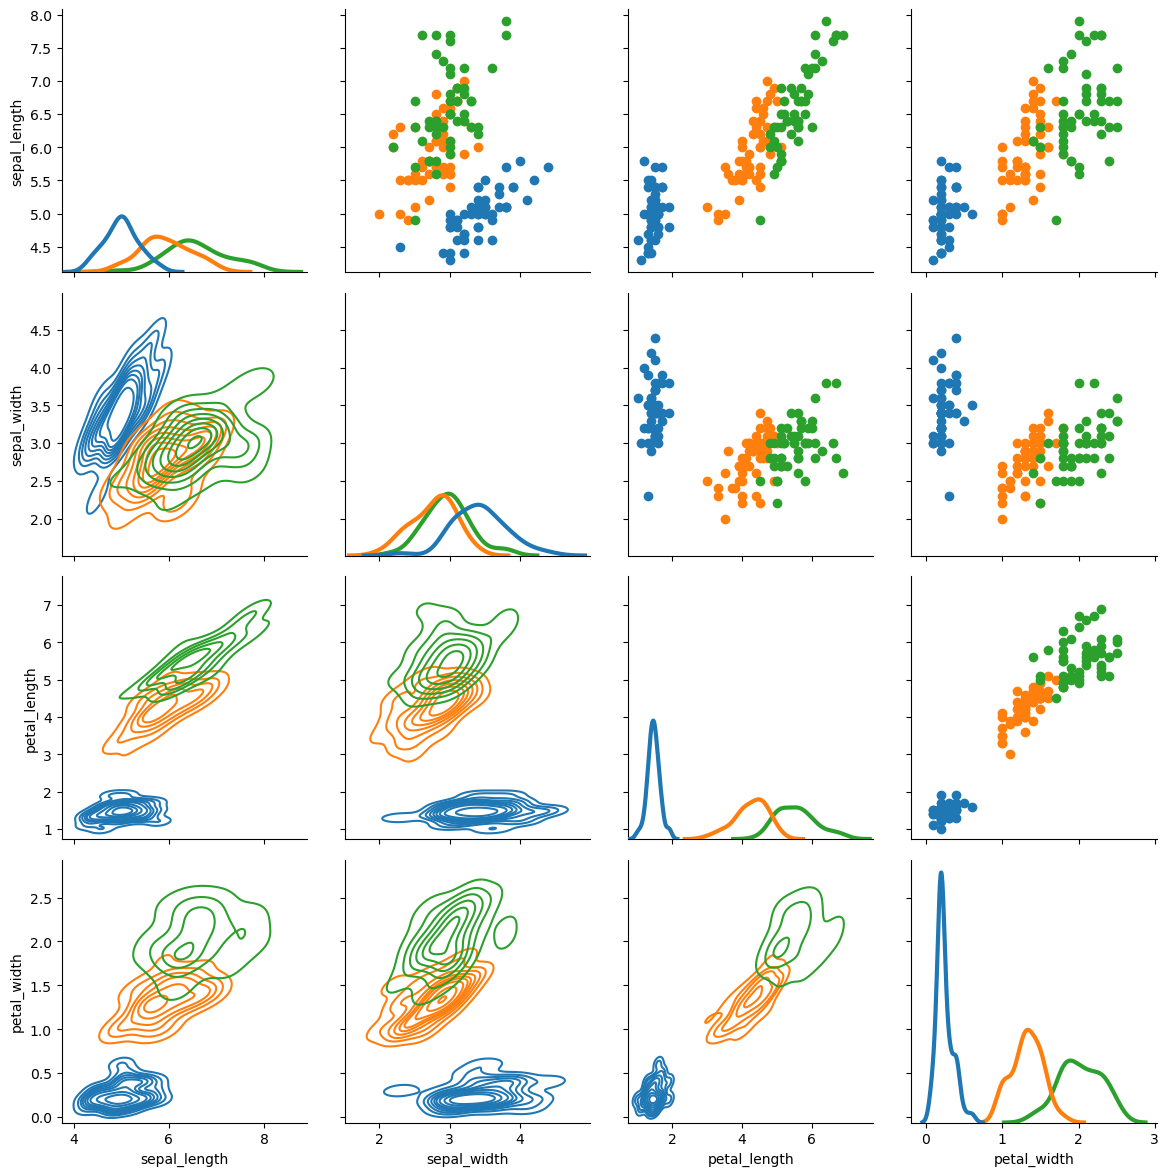

In [99]:
df = sns.load_dataset("iris")

g = sns.PairGrid(df, hue='species', size=3)
g.map_lower(sns.kdeplot, cmap ="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3);

Как выглядят данные

In [100]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Виды ирисов

In [101]:
np.unique(df.species)

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [102]:
sps.ttest_ind(df[df.species == 'setosa'].sepal_length, 
              df[df.species == 'versicolor'].sepal_length,
              equal_var=False)

Ttest_indResult(statistic=-10.52098626754911, pvalue=3.746742613983842e-17)

In [103]:
sps.ttest_ind(df[df.species == 'virginica'].sepal_length, 
              df[df.species == 'versicolor'].sepal_length,
              equal_var=False)

Ttest_indResult(statistic=5.629165259719801, pvalue=1.8661443873771216e-07)

In [104]:
sps.ttest_ind(df[df.species == 'virginica'].sepal_width, 
              df[df.species == 'versicolor'].sepal_width,
              equal_var=False)

Ttest_indResult(statistic=3.2057607502218186, pvalue=0.001819483482104968)

*Замечание.* Строго говоря, неоходима поправка на множественное тестирование гипотез.